In [185]:
# import libraries 
import pandas as pd  
import numpy as np
import sqlite3  
import statsmodels.api as sm
from statsmodels.formula.api import ols 
from scipy import stats
from statsmodels.stats.power import TTestIndPower, TTestPower 

import seaborn as sns 
import matplotlib.pyplot as plt 
%matplotlib inline 
sns.set_style('darkgrid')

In [231]:
def bootstrap(A, B):
    universe = list(A) + list(B)
    universe_shuffled = np.random.choice(universe, size=len(universe), replace=True)
    new_a = universe_shuffled[:len(A)]
    new_b = universe_shuffled[len(A):]
    return new_a, new_b

In [257]:
def one_sample_ttest(sample, popmean, alpha):

    # Visualize sample distribution for normality 
    sns.set(color_codes=True)
    sns.set(rc={'figure.figsize':(12,10)})
    sns.distplot(sample)
    
    # Population mean 
    mu = popmean
    
    # Sample mean (x̄) using NumPy mean()
    x_bar= sample.mean()

    # Sample Standard Deviation (sigma) using Numpy
    sigma = np.std(sample)
    
    # Degrees of freedom
    df = len(sample) - 1
    
    #Calculate the critical t-value
    t_crit = stats.t.ppf(1 - alpha, df=df)
    
    #Calculate the t-value and p-value
    results = stats.ttest_1samp(a= sample, popmean= mu)         
    
    if (results[0]>t_crit) and (results[1]<alpha):
        print ("Null hypothesis rejected. Results are statistically significant with t-value =", 
                round(results[0], 2), "critical t-value =", t_crit, "and p-value =", np.round((results[1]), 10))
    else:
        print ("Null hypothesis is True with t-value =", 
                round(results[0], 2), ", critical t-value =", t_crit, "and p-value =", np.round((results[1]), 10))
    

In [294]:
def welch_t(a, b):
    
    """ Calculate Welch's t-statistic for two samples. """

    numerator = a.mean() - b.mean()
    
    # “ddof = Delta Degrees of Freedom”: the divisor used in the calculation is N - ddof, 
    #  where N represents the number of elements. By default ddof is zero.
    
    denominator = np.sqrt(a.var(ddof=1)/a.size + b.var(ddof=1)/b.size)
    
    return np.abs(numerator/denominator)

In [310]:
def welch_df(a, b):
    
    """ Calculate the effective degrees of freedom for two samples. """
    
    s1 = a.var(ddof=1) 
    s2 = b.var(ddof=1)
    n1 = a.size
    n2 = b.size
    
    numerator = (s1/n1 + s2/n2)**2
    denominator = (s1/ n1)**2/(n1 - 1) + (s2/ n2)**2/(n2 - 1)
    
    return numerator/denominator

In [2]:
#connect to server
conn = sqlite3.connect(r'C:\Users\krisdavis\Documents\GitHub\Topic_11\dsc-case-study-hypothesis-testing\data\northWind.sqlite')
cur = conn.cursor()

In [ ]:
#preview data table names
cur.execute("select * from sqlite_master").fetchall()

# Question 1: Is there a difference in quantity of products sold by discount rate? 

#### Data Observations and Assumptions  
Observations
1. Chai has the highest quantity sold at 45 units/ 0.20 discount 
2. Charteuse verte sold 42 units at a 0.00 discoun
3. The majority of the units represent multiple items 

Assumptions
1. Currency is in US Dollars
2. The discount represents a dollar amount not precentage
3. A high ReorderLevel is desirable

## Querring the Data

In [ ]:
# orderdetail df
cur.execute("""SELECT SupplierId, OrderId, ProductId, CategoryId, CategoryName,  
                      OrderDetail.UnitPrice, Quantity, Discount, ProductName, QuantityPerUnit, UnitsOnOrder, ReorderLevel
               FROM OrderDetail  
               JOIN Product 
               ON Product.Id = OrderDetail.ProductId 
               JOIN Category  
               ON Product.CategoryId = Category.Id   
               ORDER BY Category.CategoryName;""")
product_df = pd.DataFrame(cur.fetchall()) 
product_df.columns = [x[0] for x in cur.description]
product_df

In [ ]:
#cast needed columns as int/floats
product_df['UnitPrice'] = product_df['UnitPrice'].astype(float)
product_df['Quantity'] = product_df['Quantity'].astype(int)
product_df['Discount'] = product_df['Discount'].astype(float) 

#create a % off column 
product_df['percentage_off'] = round((product_df.Discount / product_df.UnitPrice) * 100)
product_df

In [ ]:
#all items Quantity v Discount
sns.barplot(data=product_df, x="Quantity", y="Discount")

In [ ]:
#querry just beverages
cur.execute("""SELECT SupplierId, OrderId, ProductId, CategoryId, CategoryName, 
                    OrderDetail.UnitPrice, Quantity, Discount, QuantityPerUnit, ReorderLevel
               FROM OrderDetail 
               JOIN Product  
               ON Product.Id = OrderDetail.ProductId   
               JOIN Category  
               ON Product.CategoryId = Category.Id   
               WHERE Category.CategoryName = 'Beverages' 
               ORDER BY ProductId;""")
beverages_df = pd.DataFrame(cur.fetchall()) 
beverages_df.columns = [x[0] for x in cur.description]
beverages_df

In [ ]:
#cast needed columns as int/floats
beverages_df['UnitPrice'] = beverages_df['UnitPrice'].astype(float)
beverages_df['Quantity'] = beverages_df['Quantity'].astype(int)
beverages_df['Discount'] = beverages_df['Discount'].astype(float) 

#create a % off column 
beverages_df['percentage_off'] = round(((beverages_df.Discount / beverages_df.UnitPrice) * 100), 2)
beverages_df

In [ ]:
#beverages Quantity v Discount
sns.barplot(data=beverages_df, x="Quantity", y="Discount")

In [ ]:
#just look at 15$ outback lager
outback_lager_df = beverages_df.loc[(beverages_df['ProductId'] == 70) & (beverages_df['UnitPrice'] == 15.0)] 
outback_lager_df 

In [ ]:
#Outback Lager Quantity v Discount
sns.barplot(data=outback_lager_df, x="Quantity", y="Discount")

In [323]:
#find out more about supplier 7
cur.execute("""SELECT *
               FROM Supplier 
               WHERE Id = 7
              """)
supplier_df = pd.DataFrame(cur.fetchall()) 
supplier_df.columns = [x[0] for x in cur.description]
supplier_df

,Id,CompanyName,ContactName,ContactTitle,Address,City,Region,PostalCode,Country,Phone,Fax,HomePage
0,7,"Pavlova, Ltd.",Ian Devling,Marketing Manager,74 Rose St. Moonie Ponds,Melbourne,Victoria,3058,Australia,(03) 444-2343,(03) 444-6588,None


## Starting The Experiment

In [ ]:
#caluclate the sample size needed for alpha values [0.1, 0.5, 0.01] & sell rate increase of [0.005, 0.01, 0.5, 0.2] 
sd = 0.0475
e_sizes = [mu_delta/sd for mu_delta in [.005,.01,.02, .5]]
fig, axes = plt.subplots(ncols=1, nrows=3, figsize=(8,15))
for n, alpha in enumerate([.01, .05, .1]):
    print(type(n), alpha)
    ax = axes[n]
    power_anaylsis.plot_power(dep_var="nobs",
                              nobs = np.array(range(5,500)),
                              effect_size=e_sizes,
                              alpha=alpha,
                              ax=ax)
    ax.set_title('Power of Test for alpha = {}'.format(alpha))
    ax.set_xticks(list(range(0,500,25)))
    ax.set_yticks(np.linspace(0,1,11))

In [ ]:
#drop all but the numerial values for outback lager 15$
numerical_df = outback_lager_df.drop(['SupplierId', 'OrderId', 'ProductId', 'CategoryId', 
                                      'CategoryName', 'QuantityPerUnit', 'ReorderLevel'], axis=1) 
numerical_df

## What affect does discount rate have on quantity of sales by Pavlov, Ltd of Outback Lager at unit price 15?

In [146]:
#Subset into percentage groups .33, .67, 1.33, 1.67
percent0 = numerical_df.loc[outback_lager_df['percentage_off']==0.00] 
percent33 = numerical_df.loc[outback_lager_df['percentage_off']==0.33] 
percent133 = numerical_df.loc[outback_lager_df['percentage_off']==1.33]
percent167 = numerical_df.loc[outback_lager_df['percentage_off']==1.33]

In [ ]:
#plot the distribution of each 
sns.distplot(percent0)
sns.distplot(percent33)
sns.distplot(percent133)
sns.distplot(percent167) 

In [ ]:
#ANOVA Testing 
formula = 'Quantity ~ C(percentage_off)'
lm = ols(formula, numerical_df).fit()
table = sm.stats.anova_lm(lm, typ=2)
print(table)

### Finding the mean sales at each discount rate

In [343]:
#population mean
pop_mean = round(numerical_df['Quantity'].sum()/len(numerical_df['Quantity']), 3)

#mean quantity at each percentage off   
mu_0 = round(percent0['Quantity'].sum()/len(percent0['Quantity']), 3)
mu_33 = round(percent33['Quantity'].sum()/len(percent33['Quantity']), 3)
mu_133 = round(percent133['Quantity'].sum()/len(percent133['Quantity']), 3)
mu_167 = round(percent167['Quantity'].sum()/len(percent167['Quantity']), 3)

print(f"Average Sales(Population Mean): {pop_mean}") 
print(f"0.00% Off Average Sales (0Cent Discount Mean): {mu_0}") 
print(f"0.33% Off Average Sales (5Cent Discount Mean): {mu_33}") 
print(f"1.33% Off Average Sales (20Cent Discount Mean): {mu_133}")
print(f"1.67% Off Average Sales (25Cent Discount Mean: {mu_167}")

Average Sales(Population Mean): 19.857
0.00% Off Average Sales (0Cent Discount Mean): 18.188
0.33% Off Average Sales (5Cent Discount Mean): 21.0
1.33% Off Average Sales (20Cent Discount Mean): 27.333
1.67% Off Average Sales (25Cent Discount Mean: 27.333


In [ ]:
#distribution of sales by percentage off 
ax = sns.barplot(x="percentage_off", y="Quantity", data=numerical_df)

### No Discount 

    H0: The is no change in the quantity of sales when no discount is applied. 

    HA:The quantity of sales decreases by at least 1% when no discount rate is applied.

In [182]:
#ttest 0.00  - No Discount Applied  

# Population mean (μ)
mu = pop_mean

# Sample mean (x̄) using NumPy mean()
x_bar = mu_0

# Sample Stadrad Deviation (sigma) using Numpy
sigma = np.std(percent0['Quantity'],ddof=1)

# Sample size (n)
n = len(percent0['Quantity'])

# Degrees of Freedom
df = n-1

# Difference in sample mean 
diff = x_bar - mu


# Print the findings
print ('The sample contains', n, 'observations, having a mean of', x_bar, "and a standard deviation (sigma) = ", sigma, 
       ", with", df, 'degrees of freedom. The difference between sample and population means is:', diff) 

The sample contains 16 observations, having a mean of 18.188 and a standard deviation (sigma) =  15.371917035078393 , with 15 degrees of freedom. The difference between sample and population means is: -1.6690000000000005


In [244]:
#pvalue of .00 percent off 
pop = [14, 6, 7, 15, 20, 15, 40, 50, 30, 8, 28, 40, 35, 5, 6, 9, 12, 30, 30, 4, 50, 30, 4, 50, 30, 3, 20, 30, 4, 3, 12]
zero= [6, 7, 20, 50, 40, 35, 5, 6, 9, 12, 30, 4, 30, 30, 4, 3]

num = np.mean(pop) - np.mean(zero)
s = np.var(pop+zero)
n = len(pop+zero)
denom = s/np.sqrt(n)
t = num / denom
pval = stats.t.sf(np.abs(t), n-1)*2
print(pval)

0.9407452034519197


In [248]:
iterations = 10**4
diff_mu_a_b = np.mean(pop) - np.mean(zero)
num = 0 #Initialize numerator
for n in range(iterations):
    ai, bi = bootstrap(pop, zero)
    diff_mu_ai_bi = np.mean(ai) - np.mean(bi)
    if diff_mu_ai_bi >= diff_mu_a_b:
        num +=1
p_val = num / iterations
print('P-value: {}'.format(p_val))

P-value: 0.2991


Null hypothesis is True with t-value = -0.0 , critical t-value = 1.7530503556925547 and p-value = 0.9998979039


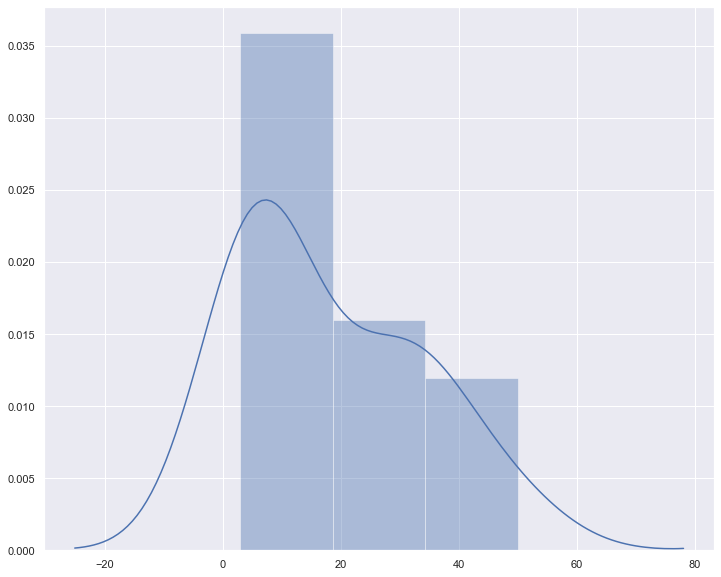

In [260]:
popmean = 18.188
alpha = 0.05 
sample = np.array([6, 7, 20, 50, 40, 35, 5, 6, 9, 12, 30, 4, 30, 30, 4, 3])
one_sample_ttest(sample, popmean, alpha)

#### Analysis 
With an applied bootstrap our pval drops from 0.94 to 0.29 however we still fail to reject the null hypothesis. 

### .33% Discount  


    H0: The is no change in the quantity of sales at discount rate .33. 

    HA:The quantity of sales increases by at least 1% when sold at a .33% discount rate.

In [344]:
#ttest 33
# Population mean (μ)
mu = 18.188

# Sample mean (x̄) using NumPy mean()
x_bar = mu_33

# Sample Stadrad Deviation (sigma) using Numpy
sigma = np.std(percent33['Quantity'],ddof=1)

# Sample size (n)
n = len(percent33['Quantity'])

# Degrees of Freedom
df = n-1

# Difference in sample mean 
diff = x_bar - mu


# Print the findings
print ('The sample contains', n, 'observations, having a mean of', x_bar, "and a standard deviation (sigma) = ", sigma, 
       ", with", df, 'degrees of freedom. The difference between sample and population means is:', diff) 

The sample contains 3 observations, having a mean of 21.0 and a standard deviation (sigma) =  16.822603841260722 , with 2 degrees of freedom. The difference between sample and population means is: 2.812000000000001


In [ ]:
#pvalue of .33 percent off
pop = [14, 6, 7, 15, 20, 15, 40, 50, 30, 8, 28, 40, 35, 5, 6, 9, 12, 30, 30, 4, 50, 30, 4, 50, 30, 3, 20, 30, 4, 3, 12]
b_33= [15, 40, 8]

num = np.mean(pop) - np.mean(b_33)
s = np.var(pop+b_33)
n = len(pop+b_33)
denom = s/np.sqrt(n)
t = num / denom
pval = stats.t.sf(np.abs(t), n-1)*2
print(pval)

In [347]:
iterations = 10**4
diff_mu_a_b = np.mean(pop) - np.mean(b_33)
num = 0 #Initialize numerator
for n in range(iterations):
    ai, bi = bootstrap(pop, b_33)
    diff_mu_ai_bi = np.mean(ai) - np.mean(bi)
    if diff_mu_ai_bi >= diff_mu_a_b:
        num +=1
p_val = num / iterations
print('P-value: {}'.format(p_val))

P-value: 0.6274


Null hypothesis is True with t-value = 0.29 , critical t-value = 2.919985580355516 and p-value = 0.7994363304


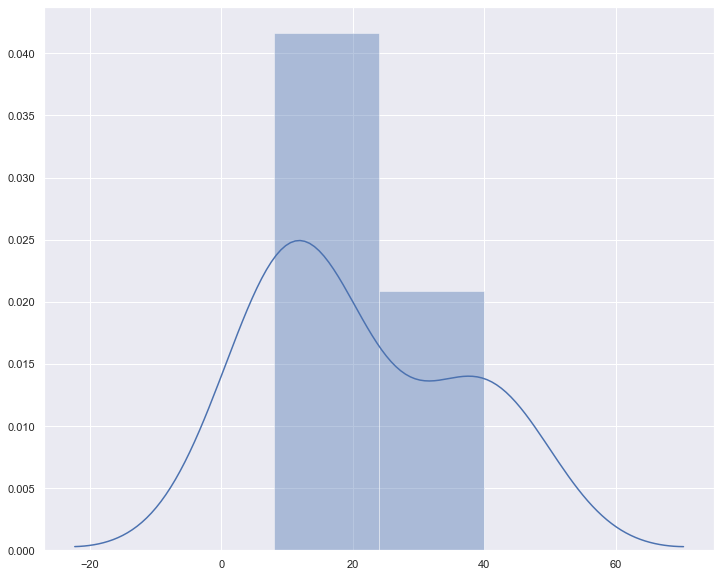

In [348]:
popmean = 18.188
alpha = 0.05 
sample = np.array([15, 40, 8])
one_sample_ttest(sample, popmean, alpha)

#### Analysis 
With an applied bootstrap our pval drops from 0.99 to 0.52 however we still fail to reject the null hypothesis.

### 1.33% Discount

    H0: The is no change in the quantity of sales at discount rate 1.33. 

    HA:The quantity of sales increases by at least 1% when sold at a 1.33% discount rate.

In [219]:
#ttest 133
# Population mean (μ)
mu = pop_mean

# Sample mean (x̄) using NumPy mean()
x_bar133 = mu_133

# Sample Stadrad Deviation (sigma) using Numpy
sigma = np.std(percent133['Quantity'],ddof=1)

# Sample size (n)
n = len(percent133['Quantity'])

# Degrees of Freedom
df = n-1

# Difference in sample mean 
diff = x_bar133 - mu


# Print the findings
print ('The sample contains', n, 'observations, having a mean of', x_bar, "and a standard deviation (sigma) = ", sigma, 
       ", with", df, 'degrees of freedom. The difference between sample and population means is:', diff) 

The sample contains 3 observations, having a mean of 27.333 and a standard deviation (sigma) =  20.033305601755625 , with 2 degrees of freedom. The difference between sample and population means is: 7.475999999999999


In [251]:
#pvalue of 1.33 percent off
pop = [14, 6, 7, 15, 20, 15, 40, 50, 30, 8, 28, 40, 35, 5, 6, 9, 12, 30, 30, 4, 50, 30, 4, 50, 30, 3, 20, 30, 4, 3, 12]
b_133= [50, 20, 12]

num = np.mean(pop) - np.mean(b_133)
s = np.var(pop+b_133)
n = len(pop+b_133)
denom = s/np.sqrt(n)
t = num / denom
pval = stats.t.sf(np.abs(t), n-1)*2
print(pval)

0.8679331935113082


In [252]:
iterations = 10**4
diff_mu_a_b = np.mean(pop) - np.mean(b_133)
num = 0 #Initialize numerator
for n in range(iterations):
    ai, bi = bootstrap(pop, b_133)
    diff_mu_ai_bi = np.mean(ai) - np.mean(bi)
    if diff_mu_ai_bi >= diff_mu_a_b:
        num +=1
p_val = num / iterations
print('P-value: {}'.format(p_val))

P-value: 0.7686


Null hypothesis is True with t-value = 0.79 , critical t-value = 2.919985580355516 and p-value = 0.5119921439


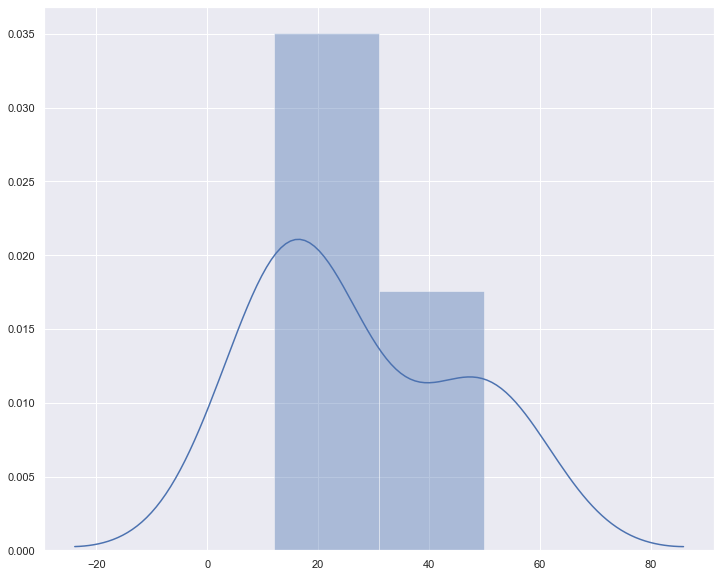

In [262]:
popmean = 18.188
alpha = 0.05 
sample = np.array([50, 20, 12])
one_sample_ttest(sample, popmean, alpha)

### Analysis: 
With an applied bootstrap our pval drops from 0.87 to 0.77 however we still fail to reject the null hypothesis

### 1.67% Discount  


    H0: The is no change in the quantity of sales at discount rate 1.67. 

    HA:The quantity of sales increases by at least 1% when sold at a 1.67% discount rate.

In [181]:
#ttest 167
# Population mean (μ)
mu = pop_mean

# Sample mean (x̄) using NumPy mean()
x_bar = mu_167

# Sample Stadrad Deviation (sigma) using Numpy
sigma = np.std(percent167['Quantity'],ddof=1)

# Sample size (n)
n = len(percent167['Quantity'])

# Degrees of Freedom
df = n-1

# Difference in sample mean 
diff = x_bar - mu


# Print the findings
print ('The sample contains', n, 'observations, having a mean of', x_bar, "and a standard deviation (sigma) = ", sigma, 
       ", with", df, 'degrees of freedom. The difference between sample and population means is:', diff) 

The sample contains 3 observations, having a mean of 27.333 and a standard deviation (sigma) =  20.033305601755625 , with 2 degrees of freedom. The difference between sample and population means is: 7.475999999999999


In [254]:
#pvalue of 1.67 percent off
pop = [14, 6, 7, 15, 20, 15, 40, 50, 30, 8, 28, 40, 35, 5, 6, 9, 12, 30, 30, 4, 50, 30, 4, 50, 30, 3, 20, 30, 4, 3, 12]
b_167= [50, 20, 12]

num = np.mean(pop) - np.mean(b_167)
s = np.var(pop+b_167)
n = len(pop+b_167)
denom = s/np.sqrt(n)
t = num / denom
pval = stats.t.sf(np.abs(t), n-1)*2
print(pval)

0.8679331935113082


In [255]:
iterations = 10**4
diff_mu_a_b = np.mean(pop) - np.mean(b_167)
num = 0 #Initialize numerator
for n in range(iterations):
    ai, bi = bootstrap(pop, b_167)
    diff_mu_ai_bi = np.mean(ai) - np.mean(bi)
    if diff_mu_ai_bi >= diff_mu_a_b:
        num +=1
p_val = num / iterations
print('P-value: {}'.format(p_val))

P-value: 0.7652


Null hypothesis is True with t-value = 0.79 , critical t-value = 2.919985580355516 and p-value = 0.5119921439


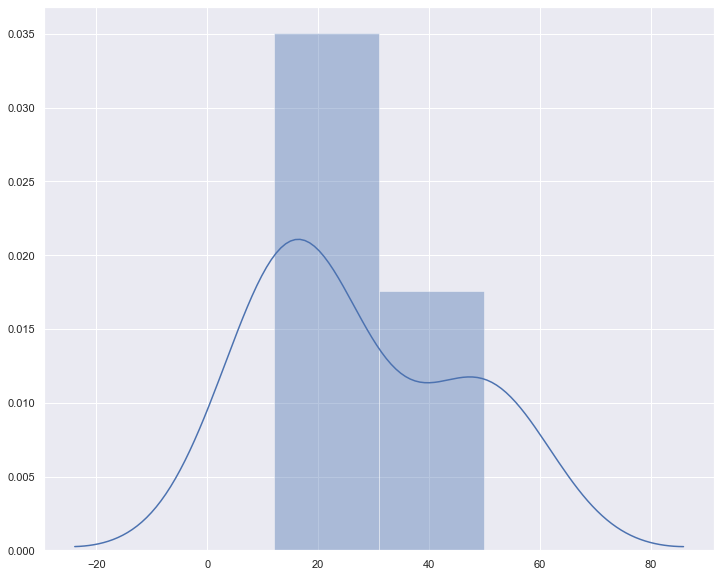

In [263]:
popmean = 18.188
alpha = 0.05 
sample = np.array([50, 20, 12])
one_sample_ttest(sample, popmean, alpha)

### Analysis:  
With an applied bootstrap our pval drops from 0.86 to 0.77 however we still fail to reject the null hypothesis.

## Building a DF to directly compare hypothetical randomly generated quanities for each discount rate

In [ ]:
#Generate random numbers in data to expand sample size 
import random

randomlist = random.sample(range(2, 51), 28)
print(randomlist) 

pop = np.array([14, 6, 7, 15, 20, 15, 40, 50, 30, 8, 28, 40, 35, 5, 6, 9, 12, 30, 30, 4, 50, 30, 4, 50, 30, 3, 20, 30, 4, 3, 12])
zero_rand= np.array([6, 7, 20, 50, 40, 35, 5, 6, 9, 12, 30, 4, 30, 30, 4, 3, 30, 43, 2, 35, 49, 26, 44, 47, 21, 23, 45, 9, 46, 6, 27])
rand_33= np.array([15, 40, 8, 22, 35, 33, 15, 46, 31, 23, 5, 38, 32, 13, 36, 44, 27, 2, 18, 8, 39, 42, 24, 17, 47, 3, 49, 45, 7, 30, 6]) 
rand_133 = np.array([50, 20, 12, 18, 35, 31, 43, 28, 9, 15, 27, 11, 50, 5, 36, 29, 12, 14, 20, 30, 19, 23, 48, 7, 42, 46, 40, 26, 22, 17, 34])
rand_167 = np.array([50, 20, 12, 15, 16, 17, 12, 24, 22, 41, 39, 26, 20, 4, 43, 3, 32, 49, 5, 45, 25, 13, 7, 28, 34, 14, 40, 44, 37, 36, 42])

In [ ]:
#DF of quantity sold by percent discount 
df = pd.DataFrame(list(zip(pop, zero_rand, rand_33, rand_133, rand_167)), 
                  columns =['popquantities', 'quantities0', 'quantities33', 'quantites133', 'quantites167'], dtype=int) 
df

In [300]:
#mean of hypothetical lists
popmean = 20.645161
zeromean = 24.000000
mean33 = 25.806452
mean133 = 26.419355
mean167 = 26.290323

In [ ]:
# ANOVA 
formula = 'popquantities ~ C(quantities33) + C(quantites133) + C(quantites167) + quantities0' 
lm = ols(formula, df).fit()
table = sm.stats.anova_lm(lm, typ=2)
print(table)

## Pop to Zero 

In [304]:
#Welch's Ttest pop/ 0 discount
a = pop
b = zero_rand
welch_t(a, b)

0.8318864275257802

In [311]:
#degree of freedom
a = pop
b = zero_rand
welch_df(a, b)

59.65459771058358

In [318]:
#pval
p = 1 - stats.t.cdf(0.8318864275257802, 59.65459771058358)
print(p) 

0.20439540047279947


In [ ]:
#Visualize density
sns.kdeplot(data=zero_rand)
sns.despine()

## Pop To 0.33

In [306]:
#Welch's Ttest pop/ .33 discount
a = pop
b = rand_33
welch_t(a, b)

1.3470100620554153

In [312]:
#degree of freedom
a = pop
b = rand_33
welch_df(a, b)

59.96700889639937

In [317]:
#pval
p = 1 - stats.t.cdf(1.3470100620554153, 59.96700889639937)
print(p) 

0.09152272024147734


In [ ]:
#visulaize density
sns.kdeplot(data=rand_33)
sns.despine()

## Pop To 1.33

In [307]:
#Welche's Ttest pop/ 1.33 discount
a = pop
b = rand_133
welch_t(a, b)

1.5862836209834563

In [313]:
#degree of freedom
a = pop
b = rand_133
welch_df(a, b)

58.941248473924816

In [319]:
#pval
p = 1 - stats.t.cdf(1.5862836209834563, 58.941248473924816)
print(p) 

0.05901293368378724


In [ ]:
#visulaize density
sns.kdeplot(data=rand_133)
sns.despine()

## Pop To 1.67

In [309]:
#Welch's Ttest pop/ 1.67 discount
a = pop
b = rand_167
welch_t(a, b)

1.5012861420682635

In [314]:
#degree of freedom
a = pop
b = rand_167
welch_df(a, b)

59.76491168123537

In [320]:
#pval
p = 1 - stats.t.cdf(1.5012861420682635, 59.76491168123537)
print(p) 

0.0692733674443099


In [ ]:
#visualizing density
sns.kdeplot(data=rand_167)
sns.despine()

## Conclusion

C:\Users\krisdavis\Anaconda4\lib\site-packages\seaborn\axisgrid.py:1840: UserWarning: JointGrid annotation is deprecated and will be removed in a future release.
  warnings.warn(UserWarning(msg))


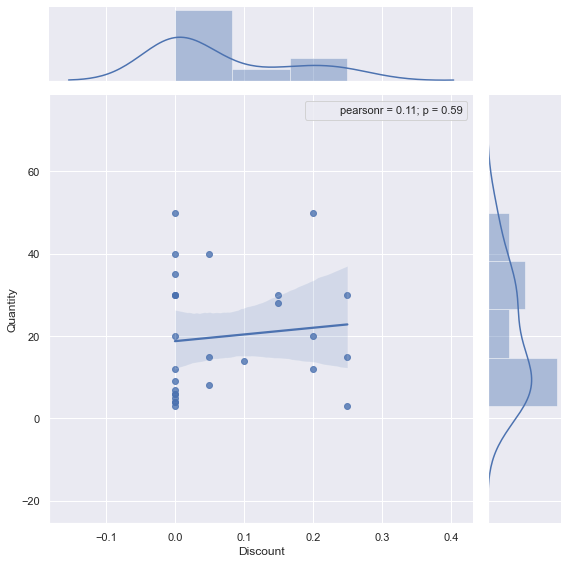

In [340]:
sns.set(style="darkgrid", color_codes=True)
j = sns.jointplot('Discount', 'Quantity', data = numerical_df, kind='reg', height=8).annotate(stats.pearsonr)
plt.show()

I failed to reject the null hypothesis at 0.00, 0.33, 1.33, and 1.67 % discount rate. This leads me to the recommendation that Pavlov, Ltd should stop discounting their Outback Lager as it does not lead to higher sales.

## EffectSize/PowerAnalysis/Tukey Testing (if needed)

# Question 2: Is there a difference in number of orders and territory? 

In [2]:
# obtain necessary data

## {Put test name here}
H0: 

HA:

In [4]:
# perform test

## Conclusion

# Question 3: {You decide}

In [2]:
# obtain necessary data

## {Put test name here}
H0: 

HA:

In [4]:
# perform test

## Conclusion

## EffectSize/PowerAnalysis/Tukey Testing (if needed)